In [1]:
import sys
import os
sys.path.append('..')
from lib.path import get_training_data_dir, get_predicted_labeled_water_path, get_displaceable_water_path, get_non_displaceable_water_path
from lib.pdb import filter_atoms_and_create_new_pdb
from data_loader.SingleDataLoader import SingleDataLoader
from data_loader.DoubleDataLoader import DoubleDataLoader
from models.LeNet import LeNet
from models.ResNet import ResNet
from models.ResNet_revised import ResNet_revised
from lib.helper import get_latest_checkpoint
from tensorflow.keras.losses import BinaryCrossentropy
from custom_losses.dice import dice_loss, dice_coefficient
from tensorflow.keras.metrics import Recall, Precision, Accuracy, SpecificityAtSensitivity, AUC, F1Score
from sklearn.metrics import fbeta_score, confusion_matrix
import numpy as np

2024-09-03 09:31:18.491664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-03 09:31:18.504209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 09:31:18.517807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 09:31:18.521855: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 09:31:18.532235: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf

# GPUを無効化
# tf.config.set_visible_devices([], 'GPU')

In [3]:
DATA_TYPE1 = 'gr'
# DATA_TYPE2 = 'Protein'
DATA_VOXEL_NUM = 10
CLASSIFYING_RULE = 'WaterClassifyingRuleSurface'
LIGAND_POCKET_DEFINER = 'LigandPocketDefinerOriginal'
LIGAND_VOXEL_NUM = 8
MODEL_NAME = 'ResNet'
TRAINER_NAME = 'aug_train'
training_data_dir1 = get_training_data_dir(DATA_TYPE1, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)
# training_data_dir2 = get_training_data_dir(DATA_TYPE2, DATA_VOXEL_NUM, CLASSIFYING_RULE, LIGAND_POCKET_DEFINER, LIGAND_VOXEL_NUM)

data_dir = '../../data'
test_list = os.path.join(data_dir, 'valid_test.txt')
data_loader = SingleDataLoader(training_data_dir1)
# data_loader = DoubleDataLoader(training_data_dir1, training_data_dir2)
test_data, test_data_label = data_loader.load_data(test_list)
print(test_data.shape)

(7657, 21, 21, 21, 1)


In [4]:
input_shape = (DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, DATA_VOXEL_NUM*2+1, test_data.shape[-1])
n_base = 8
BN = True

In [5]:
checkpoint_dir = f'../checkpoints/valid/{DATA_TYPE1}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
# checkpoint_dir = f'../checkpoints/{DATA_TYPE1}_{DATA_TYPE2}/data_voxel_num_{DATA_VOXEL_NUM}/{LIGAND_POCKET_DEFINER}/ligand_pocket_voxel_num_{LIGAND_VOXEL_NUM}/{CLASSIFYING_RULE}/{MODEL_NAME}/{TRAINER_NAME}/'
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
model = ResNet(n_base=n_base, input_shape=input_shape, learning_rate=0.0, loss=BinaryCrossentropy(), metrics=[], BN=BN)
model.load_weights(latest_checkpoint)

2024-09-03 09:31:22.414785: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22210 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:31:00.0, compute capability: 8.6
2024-09-03 09:31:22.415227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22210 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:98:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 21, 21,    │          0 │ -                 │
│ (InputLayer)        │ 21, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 21, 21,    │        224 │ input_layer[0][0] │
│                     │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 21, 21,    │         32 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 21, 21,    │          0 │ batch_normalizat… │
│ (Activation)        │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 21, 21,    │      1,736 │ activation[0][0]  │
│                     │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │         32 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 21, 21,    │          0 │ batch_normalizat… │
│ (Activation)        │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 21, 21,    │      1,736 │ activation_1[0][… │
│                     │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │         32 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 21, 21,    │          0 │ batch_normalizat… │
│                     │ 21, 8)            │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 21, 21,    │          0 │ add[0][0]         │
│ (Activation)        │ 21, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 10, 10,    │          0 │ activation_2[0][… │
│ (MaxPooling3D)      │ 10, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 10, 10,    │      3,472 │ max_pooling3d[0]… │
│                     │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │         64 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 10, 10,    │          0 │ batch_normalizat… │
│ (Activation)        │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 10, 10,    │      6,928 │ activation_3[0][… │
│                     │ 10, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 10, 10,    │        144 │ max_pooling3d[0]

 Total params: 58,081 (226.88 KB)

 Trainable params: 57,745 (225.57 KB)

 Non-trainable params: 336 (1.31 KB)

/home/ito/research/src/yuki_research/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
prediction = model.predict(test_data)
prediction_values = prediction.reshape(prediction.shape[0])
predicted_label = prediction.round()


I0000 00:00:1725323483.286014  991980 service.cc:146] XLA service 0x14f51c010ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725323483.286039  991980 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1725323483.286042  991980 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-09-03 09:31:23.297638: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-03 09:31:25.053849: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-03 09:31:25.082283: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compi

148/240 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1725323486.565749  991980 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [7]:
predicted_label.shape

(7657, 1)

In [8]:
test_data_label[6],predicted_label[6]

(0.0, array([0.], dtype=float32))

In [9]:
cm1 = confusion_matrix(test_data_label, predicted_label)

# 混同行列の要素を取り出す
tn, fp, fn, tp = cm1.ravel()

# 結果を表示
print("Confusion Matrix:")
print(cm1)
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")
negative_precision = tn / (tn + fn)
print(negative_precision)

Confusion Matrix:
[[2918  739]
 [1344 2656]]
True Negative (TN): 2918
False Positive (FP): 739
False Negative (FN): 1344
True Positive (TP): 2656
0.6846550915063351


In [10]:
# 混合行列のそれぞれの要素の正解データのラベルの配列を取得する（どのテストデータがどのように予測されているかを確認するため）
tn_index = []
fp_index = []
fn_index = []
tp_index = []

for i, (true_label, pred_label) in enumerate(zip(test_data_label, predicted_label)):
    if true_label == 0 and pred_label == 0:
        tn_index.append(i)
    elif true_label == 0 and pred_label == 1:
        fp_index.append(i)
    elif true_label == 1 and pred_label == 0:
        fn_index.append(i)
    elif true_label == 1 and pred_label == 1:
        tp_index.append(i)

In [11]:
recall = Recall()
recall.update_state(test_data_label, predicted_label)
recall_value = recall.result().numpy()

precision = Precision()
precision.update_state(test_data_label, predicted_label)
precision_value = precision.result().numpy()

accuracy = Accuracy()
accuracy.update_state(test_data_label, predicted_label)
accuracy_value = accuracy.result().numpy()

specificity = SpecificityAtSensitivity(recall_value)
specificity.update_state(test_data_label, predicted_label)
specificity_value = specificity.result().numpy()

auc = AUC()
auc.update_state(test_data_label, prediction_values)
auc_value = auc.result().numpy()

In [12]:
print({"recall": recall_value, "precision": precision_value, "accuracy": accuracy_value, "specificity": specificity_value, "dice_coefficient": dice_coefficient(test_data_label, predicted_label).numpy(), "auc": auc_value})

{'recall': 0.664, 'precision': 0.78232694, 'accuracy': 0.72796136, 'specificity': 0.7979218, 'dice_coefficient': 0.71836126, 'auc': 0.81144774}


In [13]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(test_data_label, prediction_values)

In [14]:
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold_youden = thresholds[optimal_idx]
optimal_threshold_youden

0.43157047

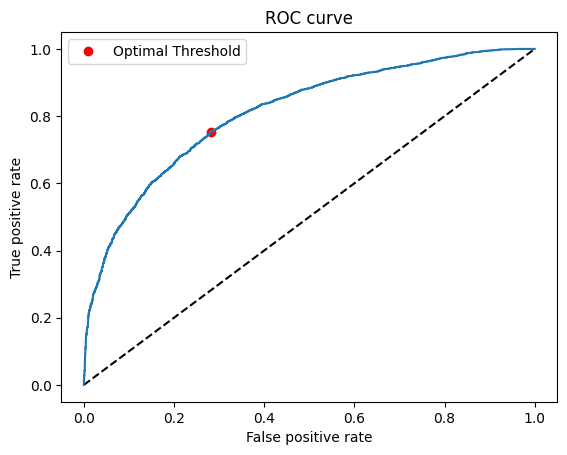

In [15]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label='Optimal Threshold')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [37]:
np.where(tpr > 0.70)[0]


array([164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
       229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
       255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267,
       268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293,
       294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
       307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
       320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332,
       333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 34

In [38]:
tpr[2356]
# thresholds[2748]

IndexError: index 2356 is out of bounds for axis 0 with size 434

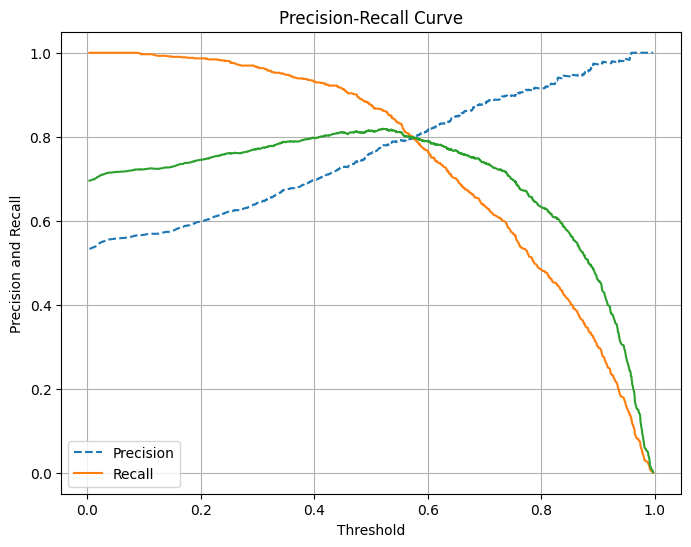

0.52163655
0.8620268620268621 0.7801104972375691


In [39]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall曲線の計算
precisions, recalls, thresholds = precision_recall_curve(test_data_label, prediction_values)
f1 = 2 * precisions * recalls / (precisions + recalls)
# Precision-Recall曲線の描画
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", linestyle='--')
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1[:-1])
plt.xlabel("Threshold")
plt.ylabel("Precision and Recall")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()
print(thresholds[np.argmax(f1)])
print(recalls[np.argmax(f1)], precisions[np.argmax(f1)])

# # 最適な閾値の選定（ここではrecallがある一定以上の場合の閾値を選ぶ例）
# target_recall = 0.8  # 目標とするrecall値
# optimal_threshold = 0.5  # 初期値

# for precision, recall, threshold in zip(precisions, recalls, thresholds):
#     if recall >= target_recall:
#         optimal_threshold = threshold
#         break

# print(f"Optimal threshold for target recall {target_recall}: {optimal_threshold}")


In [40]:
def custom_threshold(prediction, threshold):
    return (prediction > threshold).astype(int)
optimal_threshold_youden = 0.45
optimal_predicted_label = custom_threshold(prediction_values, optimal_threshold_youden)

In [41]:
recall = Recall()
recall.update_state(test_data_label, optimal_predicted_label)
optimal_recall_value = recall.result().numpy()

precision = Precision()
precision.update_state(test_data_label, optimal_predicted_label)
optimal_precision_value = precision.result().numpy()

accuracy = Accuracy()
accuracy.update_state(test_data_label, optimal_predicted_label)
optimal_accuracy_value = accuracy.result().numpy()

specificity = SpecificityAtSensitivity(optimal_recall_value)
specificity.update_state(test_data_label, optimal_predicted_label)
optimal_specificity_value = specificity.result().numpy()

f2 = fbeta_score(test_data_label, optimal_predicted_label, beta=1)


auc = AUC()
auc.update_state(test_data_label, prediction_values)
auc_value = auc.result().numpy()


In [42]:
f2

0.8104008667388949

In [43]:
cm2 = confusion_matrix(test_data_label, optimal_predicted_label)

# 混同行列の要素を取り出す
tn, fp, fn, tp = cm2.ravel()

# 結果を表示
print("Confusion Matrix:")
print(cm2)
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")
negative_precision = tn / (tn + fn)
print(negative_precision)

Confusion Matrix:
[[437 279]
 [ 71 748]]
True Negative (TN): 437
False Positive (FP): 279
False Negative (FN): 71
True Positive (TP): 748
0.860236220472441


In [44]:
print({"recall": optimal_recall_value, "precision": optimal_precision_value, "accuracy": optimal_accuracy_value, "specificity": optimal_specificity_value, "dice_coefficient": dice_coefficient(test_data_label, optimal_predicted_label).numpy(),"f2": f2, "auc": auc_value})

{'recall': 0.9133089, 'precision': 0.72833496, 'accuracy': 0.77198696, 'specificity': 0.6103352, 'dice_coefficient': 0.81050354, 'f2': 0.8104008667388949, 'auc': 0.8722843}


In [119]:
def calculate_metrics(confusion_matrix1, confusion_matrix2):
    # Sum the confusion matrices
    total_confusion_matrix = confusion_matrix1 + confusion_matrix2

    # Extract values
    TN = total_confusion_matrix[0, 0]
    FP = total_confusion_matrix[0, 1]
    FN = total_confusion_matrix[1, 0]
    TP = total_confusion_matrix[1, 1]

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    specificity = TN / (TN + FP)
    dice_coefficient = 2 * TP / (2 * TP + FP + FN)
    auc = (recall + specificity) / 2

    # Store metrics in a dictionary
    metrics = {
        'recall': recall,
        'precision': precision,
        'accuracy': accuracy,
        'specificity': specificity,
        'dice_coefficient': dice_coefficient,
        'auc': auc
    }

    return metrics

In [120]:
cm1 = [[1884,  504],
 [ 814 ,1779]]

cm1 = np.array([[1706, 682],
 [ 655, 1938]])

cm2 = np.array([[3024, 1085],
 [1196 ,3224]])

In [121]:
cm1 + cm2

array([[4730, 1767],
       [1851, 5162]])

In [122]:
print(calculate_metrics(cm1, cm2))

{'recall': 0.7360615998859261, 'precision': 0.7449848462981671, 'accuracy': 0.7321983715766099, 'specificity': 0.7280283207634293, 'dice_coefficient': 0.740496341988237, 'auc': 0.7320449603246777}
